In [1]:
import os
import cv2
import sys
import json
import math
import time
import torch
import warnings
import numpy as np
from PIL import Image, ImageDraw
from pathlib import Path

from matplotlib import pyplot as plt
#from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor



from os.path import join as pjoin
from bop_toolkit_lib import inout
warnings.filterwarnings("ignore")

base_path = os.path.dirname(os.path.abspath("."))
sys.path.append(base_path)

from lib import rendering, network

from dataset import LineMOD_Dataset, prototype_Dataset
from evaluation import utils
from evaluation import config as cfg

gpu_id = 0
# gpu_id = 1

#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
#os.environ['EGL_DEVICE_ID'] = str(gpu_id)
DEVICE = torch.device('cpu')


datapath = Path(cfg.DATA_PATH)
eval_dataset = prototype_Dataset.Dataset(datapath / 'huawei_box')
#eval_dataset = LineMOD_Dataset.Dataset(datapath / 'lm')

#cfg.RENDER_WIDTH = eval_dataset.cam_width    # the width of rendered images
#cfg.RENDER_HEIGHT = eval_dataset.cam_height  # the height of rendered images
cfg.RENDER_WIDTH = 640    # the width of rendered images
cfg.RENDER_HEIGHT = 480  # the height of rendered images

cfg.DATASET_NAME = 'huawei_box'        # dataset name
#cfg.DATASET_NAME = 'lm'        # dataset name

cfg.HEMI_ONLY = True

In [2]:
print(os.getcwd()); cfg.DATA_PATH; os.listdir()
print(eval_dataset.obj_diameter)
print(eval_dataset.cam_K)

/home/nicklas/Projects/pose_demo/example
{2: 0.2475}
tensor([[382.7990,   0.0000, 316.1090],
        [  0.0000, 382.7990, 240.3940],
        [  0.0000,   0.0000,   1.0000]])


# Load Mask-RCNN model

In [3]:
#Not needed for image test

In [4]:
################################################# MASK-RCNN Segmentation ##################################################################
#rcnnIdx_to_lmIds_dict = {0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7, 7:8, 8:9, 9:10, 10:11, 11:12, 12:13, 13:14, 14:15}
#rcnnIdx_to_lmCats_dict ={0:'Ape', 1:'Benchvice', 2:'Bowl', 3:'Camera', 4:'Can', 5:'Cat', 6:'Cup', 7:'Driller', 
#                        8:'Duck', 9:'Eggbox', 10:'Glue', 11:'Holepunch', 12:'Iron', 13:'Lamp', 14:'Phone'}
#rcnn_cfg = get_cfg()
#rcnn_cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
#rcnn_cfg.MODEL.WEIGHTS = os.path.abspath(os.path.join(base_path, 'checkpoints','lm_maskrcnn_model.pth'))
#rcnn_cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(rcnnIdx_to_lmCats_dict)
#rcnn_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.001 # the predicted category scores
#predictor = DefaultPredictor(rcnn_cfg)
################################################## MASK-RCNN Segmentation ##################################################################
#print('Mask-RCNN has been loaded!')

# Load OVE6D model

In [5]:

ckpt_file = pjoin(base_path, 
                'checkpoints', 
                "OVE6D_pose_model.pth"
                )
model_net = network.OVE6D().to(DEVICE)

model_net.load_state_dict(torch.load(ckpt_file, map_location=DEVICE))
model_net.eval()
print('OVE6D has been loaded!')

OVE6D has been loaded!


#  Load object viewpoint codebooks

In [6]:
print(eval_dataset.model_dir)
print(cfg)

Dataspace/huawei_box/models_eval
<module 'evaluation.config' from '/home/nicklas/Projects/pose_demo/evaluation/config.py'>


In [12]:

cfg.VIEWBOOK_BATCHSIZE = 200 # reduce this if out of GPU memory, 
codebook_saving_dir = pjoin(base_path,'evaluation/object_codebooks',
                            cfg.DATASET_NAME, 
                            'zoom_{}'.format(cfg.ZOOM_DIST_FACTOR), 
                            'views_{}'.format(str(cfg.RENDER_NUM_VIEWS)))



object_codebooks = utils.OVE6D_codebook_generation(codebook_dir=codebook_saving_dir, 
                                                    model_func=model_net,
                                                    dataset=eval_dataset, 
                                                    config=cfg, 
                                                    device=DEVICE)
print('Object codebooks have been loaded!')
print(object_codebooks.keys())

Loading  /home/nicklas/Projects/pose_demo/evaluation/object_codebooks/huawei_box/zoom_0.01/views_400/huawei_box_obj_02_views_400.npy
Object codebooks have been loaded!
dict_keys([2])


# Object segmentation

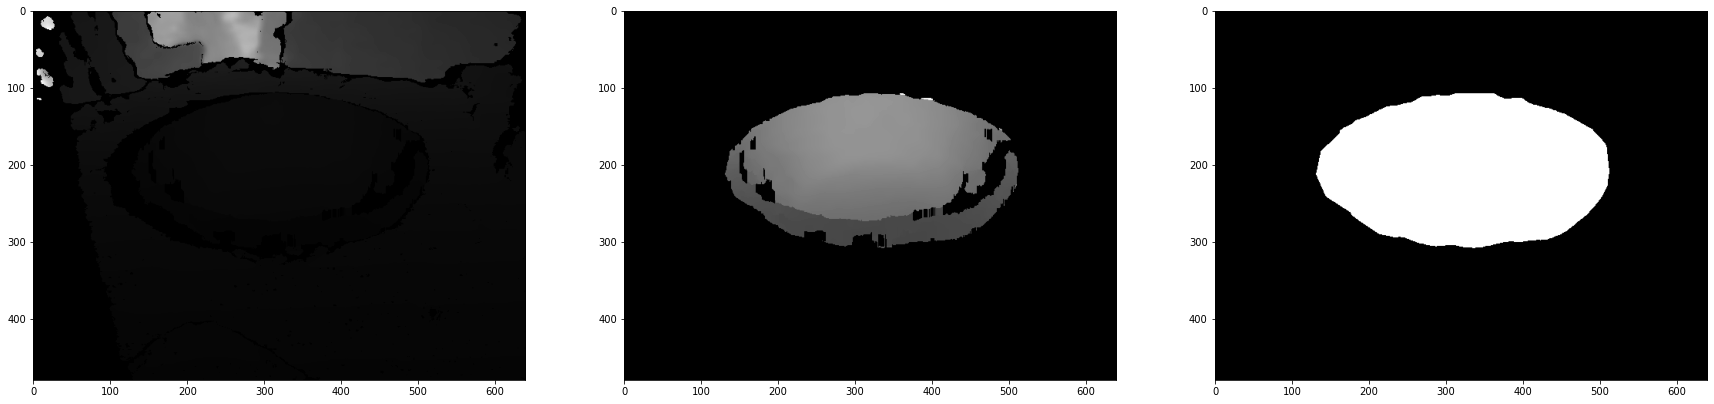

In [25]:
#files = ['1656333461794.60351562500000', '1656333463394.28930664062500',
#        '1656333465394.65112304687500', '1656333466832.90551757812500']

cfg.VP_NUM_TOPK = 50   # the retrieval number of viewpoint 
cfg.RANK_NUM_TOPK = 5  # the ranking number of full 3D orientation 
cfg.USE_ICP = False
interpolate = True

#test_data_dir = datapath / 'lm' / 'test'          # path to the test dataset of BOP
test_data_dir = datapath / 'huawei_box' / 'test'          # path to the test dataset of BOP

scene_id = 2   # range [1, 15]
view_id = 0  # range [0, 1214]

idx = 1
scene_dir = pjoin(test_data_dir, '{:06d}'.format(scene_id))

files = [f[1:-4].split('_')[1] for f in os.listdir(scene_dir+'/mask')]
#color_file = pjoin(scene_dir, 'rgb/_Color_' + files[idx] + '.png')
depth_file = pjoin(scene_dir, 'depth/_Depth_' + files[idx] + '.csv')
#mask_file = pjoin(scene_dir, 'mask_visib/{:06d}_{:06d}.png'.format(view_id, 0))
mask_file = pjoin(scene_dir, 'mask/_mask_' + files[idx] + '.png')

tar_obj_id = scene_id # object id equals the scene id for LM dataset

############## read the camera information ##############
cam_info_file = pjoin(scene_dir, 'scene_camera.json')
with open(cam_info_file, 'r') as cam_f:
    scene_camera_info = json.load(cam_f)
view_cam_info = scene_camera_info[str(view_id)]  # scene camera information
#view_cam_info = scene_camera_info[str(scene_id)]  # scene camera information   
#view_cam_info = scene_camera_info[str(0)]  # scene camera information        

############## read the ground truth pose for calculating errors ##############
#gt_pose_file = os.path.join(scene_dir, 'scene_gt.json')
#with open(gt_pose_file, 'r') as pose_f:
#    pose_anno = json.load(pose_f)
#view_pose = pose_anno[str(view_id)][0]
#obj_gt_R = cfg.BOP_REF_POSE(torch.tensor(view_pose['cam_R_m2c'], dtype=torch.float32).view(3, 3))
#obj_gt_t = torch.tensor(view_pose['cam_t_m2c'], dtype=torch.float32) * cfg.MODEL_SCALING


############## read the depth images and convert it from meter to millimeter ##############
view_depth = torch.tensor(np.loadtxt(depth_file, delimiter=",", dtype=float), dtype=torch.float32) # In meters
#view_depth = torch.tensor(np.array(Image.open(depth_fil1656333461794.60351562500000e)), dtype=torch.float32) # HxW
view_depth *= view_cam_info['depth_scale']
#view_depth *= cfg.MODEL_SCALING # convert to meter scale from millimeter scale
view_camK = torch.tensor(view_cam_info['cam_K'], dtype=torch.float32).view(3, 3)[None, ...] # 1x3x3
cam_K = view_camK.to(DEVICE)


view_depth = view_depth.to(DEVICE)
#obj_mask = torch.tensor(np.array(Image.open(mask_file)))
obj_mask = torch.tensor(np.array(Image.open(mask_file)), dtype=torch.float32)/255
obj_mask[obj_mask < 1] = 0


if interpolate: 
    closed = torch.tensor(cv2.morphologyEx((view_depth*obj_mask).numpy(), cv2.MORPH_CLOSE, np.ones(3), iterations=5), dtype=torch.float32)
    view_depth[obj_mask==1] = closed[obj_mask==1]


fig, ax = plt.subplots(1,3, figsize=(30,10))
ax = ax.flatten()
ax[0].imshow(view_depth.cpu(),cmap='gray')
ax[1].imshow(view_depth.cpu()*obj_mask.cpu(), cmap='gray')
ax[2].imshow(obj_mask.cpu(), cmap='gray')


#ax[1].imshow(obj_mask[0].cpu())

############## read rgb image for object segmentation ##############
#
### TODO:
#view_timer = time.time() 
#rgb_img = cv2.imread(color_file)
#imread_cost = time.time() - view_timer
#
#rcnn_timer = time.time()
#output = predictor(rgb_img)
#rcnn_pred_ids = output["instances"].pred_classes
#rcnn_pred_masks = output["instances"].pred_masks
#rcnn_pred_scores = output["instances"].scores
#rcnn_cost = time.time() - rcnn_timer
###################### object segmentation ######################

#tar_rcnn_d = tar_obj_id - 1
#obj_masks = rcnn_pred_masks # NxHxW
#obj_depths = view_depth[None, ...] * obj_masks
#tar_obj_depths = obj_depths[tar_rcnn_d==rcnn_pred_ids]
#tar_obj_masks = rcnn_pred_masks[tar_rcnn_d==rcnn_pred_ids]
#tar_obj_scores = rcnn_pred_scores[tar_rcnn_d==rcnn_pred_ids]

#mask_pixel_count = tar_obj_masks.view(tar_obj_masks.size(0), -1).sum(dim=1)
#valid_idx = (mask_pixel_count >= 100)
#if valid_idx.sum() == 0:
#    mask_visib_ratio = mask_pixel_count / mask_pixel_count.max()
#    valid_idx = mask_visib_ratio >= 0.05
#
#tar_obj_masks = tar_obj_masks[valid_idx] # select the target object instance masks
#tar_obj_depths = tar_obj_depths[valid_idx]
#tar_obj_scores = tar_obj_scores[valid_idx]

In [26]:
print(cam_K, cam_K.shape)

tensor([[[382.7990,   0.0000, 316.1090],
         [  0.0000, 382.7990, 240.3940],
         [  0.0000,   0.0000,   1.0000]]]) torch.Size([1, 3, 3])


# Object pose estimation

In [27]:
#print(eval_dataset.obj_model_file)
tar_obj_codebook = object_codebooks[scene_id]
obj_mesh = tar_obj_codebook['obj_mesh']
print("Diameter:", obj_mesh.bounding_diameter, "Bounding size:", obj_mesh.bounding_size, "Bounds:", obj_mesh.bounds)

Diameter: 0.2578543554074978 Bounding size: 0.25076600443571806 Bounds: [[-0.239645 -0.086929 -0.029685]
 [ 0.011121  0.16091   0.043748]]


In [28]:
obj_renderer = rendering.Renderer(width=cfg.RENDER_WIDTH, height=cfg.RENDER_HEIGHT)
pose_ret = utils.OVE6D_mask_full_pose(model_func=model_net, 
                                    #obj_depth=view_depth.clone(),
                                    obj_depth=view_depth[None,:,:],
                                    obj_mask=obj_mask[None,:,:],
                                    obj_codebook=tar_obj_codebook,
                                    cam_K=cam_K,
                                    config=cfg,
                                    obj_renderer=obj_renderer,
                                    device=DEVICE)

#pose_ret, rcnn_idx = utils.OVE6D_rcnn_full_pose(model_func=model_net, 
#                                    obj_depths=tar_obj_depths,
#                                    obj_masks=tar_obj_masks,
#                                    obj_rcnn_scores=tar_obj_scores,
#                                    obj_codebook=tar_obj_codebook, 
#                                    cam_K=cam_K,
#                                    config=cfg, 
#                                    device=DEVICE,
#                                    obj_renderer=obj_renderer, 
#                                    return_rcnn_idx=True
#                                    )
del obj_renderer

raw_pose_R = pose_ret['raw_R'] # without ICP
raw_pose_t = pose_ret['raw_t'] # without ICP
if cfg.USE_ICP:
    
    icp1_pose_R = pose_ret['icp1_R'] # with ICP after pose selection
    icp1_pose_t = pose_ret['icp1_t'] # with ICP after pose selection
    
    icpk_pose_R = pose_ret['icpk_R'] # with ICP before pose selection
    icpk_pose_t = pose_ret['icpk_t'] # with ICP before pose selection

#plt.imshow(tar_obj_masks.sum(dim=0).cpu())
#plt.axis(False)

#obj_name = rcnnIdx_to_lmCats_dict[tar_rcnn_d]

#print('object: {}, the {}-th ({:.3f}) RCNN prediction is selected for estimating 6D pose. '.format(
#    obj_name, rcnn_idx, tar_obj_scores[rcnn_idx]))
#print('RCNN confs: {}'.format(tar_obj_scores.cpu().numpy()))
print(raw_pose_R, '/n',raw_pose_t)

tensor([[ 0.0034, -0.0227,  0.2680]])
tensor([[ 0.3630,  0.8532,  0.3746],
        [-0.8402,  0.1258,  0.5275],
        [ 0.4029, -0.5062,  0.7625]]) /n tensor([[ 0.0826, -0.0949,  0.3024]])


In [29]:
tar_obj_codebook['diameter'], view_depth[obj_mask.bool()].max(), view_depth[obj_mask.bool()].min()

(0.2475, tensor(0.5930), tensor(0.))

# Visualize the predicted pose

In [30]:
from lib import geometry, rendering, three, preprocess
from evaluation import pplane_ICP
from lib import preprocess

obj_mesh = tar_obj_codebook['obj_mesh']
obj_renderer = rendering.Renderer(width=cfg.RENDER_WIDTH, height=cfg.RENDER_HEIGHT)
obj_context = rendering.SceneContext(obj=obj_mesh, intrinsic=cam_K.cpu()) # define a scene


#init_t = torch.zeros_like(raw_pose_t)
#init_t[:, -1] = 1.0
#init_R = torch.eye(3)
obj_context.set_pose(rotation=raw_pose_R, translation=raw_pose_t)

est_depth, est_mask = obj_renderer.render(obj_context)[1:]
del obj_renderer

torch.Size([480, 640])
Bounds: [[-0.239645 -0.086929 -0.029685]
 [ 0.011121  0.16091   0.043748]]
Median: tensor(0.2648)
Error: tensor(0.0431)


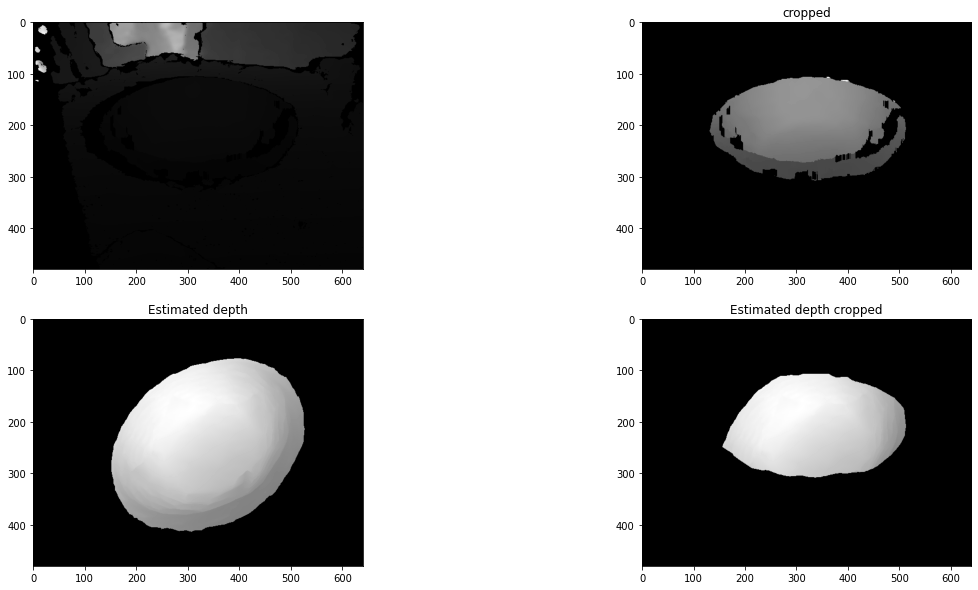

In [31]:
print(est_depth.shape)
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax = ax.flatten()
ax[0].imshow(view_depth, cmap='gray')
ax[1].imshow(view_depth*obj_mask, cmap='gray'); ax[1].set_title('cropped')
ax[2].imshow(est_depth, cmap='gray') ; ax[2].set_title('Estimated depth')
ax[3].imshow(est_depth*obj_mask, cmap='gray'); ax[3].set_title('Estimated depth cropped')
print("Bounds:", obj_mesh.bounds)
print("Median:", est_depth[est_mask.bool()].median())

### How to measure error?
print("Error:", np.abs(est_depth-obj_mask*view_depth).sum()/view_depth.numel())

In [32]:
view_depth.numel()

307200

In [33]:
import misc 

obj_mesh = tar_obj_codebook['obj_mesh']

PD_raw_pose = torch.eye(4, dtype=torch.float32)
PD_raw_pose[:3, 3] = raw_pose_t
PD_raw_pose[:3, :3] = cfg.POSE_TO_BOP(raw_pose_R)


PD_icp1_pose = torch.eye(4, dtype=torch.float32)
PD_icp1_pose[:3, 3] = icp1_pose_t
PD_icp1_pose[:3, :3] = cfg.POSE_TO_BOP(icp1_pose_R)


PD_icpk_pose = torch.eye(4, dtype=torch.float32)
PD_icpk_pose[:3, 3] = icpk_pose_t
PD_icpk_pose[:3, :3] = cfg.POSE_TO_BOP(icpk_pose_R)


#GT_pose = torch.eye(4, dtype=torch.float32)
#GT_pose[:3, :3] = obj_gt_R
#GT_pose[:3, 3] = obj_gt_t

obj_diameter = tar_obj_codebook['diameter']
corner_pts = obj_mesh.bounds  # object bounding box vertices
obj_pcl = obj_mesh.vertices
N_pcl = len(obj_pcl)
select_obj_idxes = torch.randperm(N_pcl)[:500]
select_obj_pts = torch.tensor(obj_pcl[select_obj_idxes])

#GT_2D_bbox = misc.box_2D_shape(points=corner_pts, pose=GT_pose, K=cam_K)
PD_raw_2D_bbox = misc.box_2D_shape(points=corner_pts, pose=PD_raw_pose, K=cam_K)
#PD_raw_2D_bbox = PD_raw_2D_bbox[::2]
#PD_icp1_2D_bbox = misc.box_2D_shape(points=corner_pts, pose=PD_icp1_pose, K=cam_K)
#PD_icpk_2D_bbox = misc.box_2D_shape(points=corner_pts, pose=PD_icpk_pose, K=cam_K)

#GT_shape = misc.bbox_to_shape(GT_2D_bbox.tolist())
PD_raw_shape = misc.bbox_to_shape(PD_raw_2D_bbox.tolist())
#PD_icp1_shape = misc.bbox_to_shape(PD_icp1_2D_bbox.tolist())
#PD_icpk_shape = misc.bbox_to_shape(PD_icpk_2D_bbox.tolist())

#pil_img = Image.open(color_file)
depth_map = view_depth.cpu().numpy()
depth_map /= depth_map.max()
depth_map *= 255; depth_map = depth_map.astype(np.uint8)
pil_img = Image.fromarray(depth_map)

Raw_bbox_img = pil_img.copy()
#import ipdb; ipdb.set_trace()
draw = ImageDraw.Draw(Raw_bbox_img)
#draw.line(GT_shape, (255, 0, 0), 3)      # Red 3D bbox for GT
draw.line(PD_raw_shape, (0, 0, 255), 3)  # Blue 3D bbox for OVE6D

fig, ax = plt.subplots(1,figsize=(30, 10))
ax.imshow(Raw_bbox_img, cmap='gray', vmin=0, vmax=1)
ax.axis(False)

#ICP1_bbox_img = pil_img.copy()
#draw = ImageDraw.Draw(ICP1_bbox_img)
##draw.line(GT_shape, (255, 0, 0), 3)  # Red 3D bbox for GT
#draw.line(PD_icp1_shape, (0, 255, 0), 3)  # Green 3D bbox for OVE6D with ICP after pose selection
#
#
#ICPK_bbox_img = pil_img.copy()
#draw = ImageDraw.Draw(ICPK_bbox_img)
##draw.line(GT_shape, (255, 0, 0), 3)  # Red 3D bbox for GT
#draw.line(PD_icpk_shape, (255, 0, 255), 3)  # Cyan 3D bbox for OVE6D with ICP before pose selection


##### calculate the pose errors ########
#raw_R_err = utils.rotation_error(raw_pose_R, obj_gt_R)
#icp1_R_err = utils.rotation_error(icp1_pose_R, obj_gt_R)
#icpk_R_err = utils.rotation_error(icpk_pose_R, obj_gt_R)
#
#raw_t_err = (((raw_pose_t - obj_gt_t)**2).sum())**0.5 * 1000
#icp1_t_err = (((icp1_pose_t - obj_gt_t)**2).sum())**0.5 * 1000
#icpk_t_err = (((icpk_pose_t - obj_gt_t)**2).sum())**0.5 * 1000
#
#
#raw_add_err = misc.add(R_est=raw_pose_R.numpy(), t_est=raw_pose_t.numpy(), 
#                        R_gt=obj_gt_R.numpy(), t_gt=obj_gt_t.numpy(), 
#                        pts=select_obj_pts.numpy())*1000
#raw_adi_err = misc.adi(R_est=raw_pose_R.numpy(), t_est=raw_pose_t.numpy(), 
#                        R_gt=obj_gt_R.numpy(), t_gt=obj_gt_t.numpy(), 
#                        pts=select_obj_pts.numpy())*1000
#
#icp1_add_err = misc.add(R_est=icp1_pose_R.numpy(), t_est=icp1_pose_t.numpy(), 
#                        R_gt=obj_gt_R.numpy(), t_gt=obj_gt_t.numpy(), 
#                        pts=select_obj_pts.numpy())*1000
#icp1_adi_err = misc.adi(R_est=icp1_pose_R.numpy(), t_est=icp1_pose_t.numpy(), 
#                        R_gt=obj_gt_R.numpy(), t_gt=obj_gt_t.numpy(), 
#                        pts=select_obj_pts.numpy())*1000
#
#icpk_add_err = misc.add(R_est=icpk_pose_R.numpy(), t_est=icpk_pose_t.numpy(), 
#                        R_gt=obj_gt_R.numpy(), t_gt=obj_gt_t.numpy(), 
#                        pts=select_obj_pts.numpy())*1000
#icpk_adi_err = misc.adi(R_est=icpk_pose_R.numpy(), t_est=icpk_pose_t.numpy(), 
#                        R_gt=obj_gt_R.numpy(), t_gt=obj_gt_t.numpy(), 
#                        pts=select_obj_pts.numpy())*1000



#fig, ax = plt.subplots(1,3,figsize=(30, 10))
#ax[0].imshow(Raw_bbox_img)
#ax[0].set_title("T(0.1d)={:.1f}mm, Raw R: {:.1f}˚, t: {:.1f}mm, add: {:.1f}mm, adi: {:.1f}mm".format(
#    obj_diameter * 100, raw_R_err, raw_t_err, raw_add_err, raw_adi_err), fontsize=20)
#ax[1].imshow(ICP1_bbox_img)
#ax[1].set_title("T={:.1f}mm, ICP1 R: {:.1f}˚, t: {:.1f}mm, add: {:.1f}mm, adi: {:.1f}mm".format(
#    obj_diameter * 100, icp1_R_err, icp1_t_err, icp1_add_err, icp1_adi_err), fontsize=20)
#ax[2].imshow(ICPK_bbox_img)
#ax[2].set_title("T={:.1f}mm, ICPK R: {:.1f}˚, t: {:.1f}mm, add: {:.1f}mm, adi: {:.1f}mm".format(
#    obj_diameter * 100, icpk_R_err, icpk_t_err, icpk_add_err, icpk_adi_err), fontsize=20)
#ax[0].axis(False)
#ax[1].axis(False)
#ax[2].axis(False)
#
## print('object diameter: {:.1f}mm, 0.1d:{:.1f}mm'.format(obj_diameter*1000, obj_diameter*100))
#print('GT(Red): \t {}, diameter: {:.1f}mm, pose threshold(0.1d): {:.1f}mm'.format(obj_name, obj_diameter*1000, obj_diameter*100))
#print('Raw(Blue): \t rot error:{:.1f}˚, tsl_err:{:.1f}mm, add:{:.1f}mm, adi:{:.1f}mm'.format(raw_R_err, raw_t_err, raw_add_err, raw_adi_err))
#print('ICP1(Green): \t rot error:{:.1f}˚, tsl_err:{:.1f}mm, add:{:.1f}mm, adi:{:.1f}mm'.format(icp1_R_err, icp1_t_err, icp1_add_err, icp1_adi_err))
#print('ICPK(Cyan): \t rot error:{:.1f}˚, tsl_err:{:.1f}mm, add:{:.1f}mm, adi:{:.1f}mm'.format(icpk_R_err, icpk_t_err, icpk_add_err, icpk_adi_err))



NameError: name 'icp1_pose_t' is not defined

In [ ]:
# Morhpology

kernel = np.ones(5)
#closing = cv2.morphologyEx(crop.numpy(), cv2.MORPH_CLOSE, kernel)
closing = cv2.morphologyEx(crop.numpy(), cv2.MORPH_CLOSE, kernel, iterations=8)

fig, ax = plt.subplots(1,2, figsize=(30,10))
ax[0].imshow(crop.numpy())
ax[1].imshow(closing)
view_depth = torch.tensor(closing)